# **Porter Delivery Time Estimation**

Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers 

Porter works with a wide range of restaurants for delivering their items directly to the people.


**Problem statement**


Porter has a number of delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers on the basis of what they are ordering, from where and also the delivery partners.

This dataset has the required data to train a regression model that will do the delivery time esimation, based on all those features

**Data Dictionary**

market_id : integer id for the market where the restaurant lies

created_at : the timestamp at which the order was placed

actual_delivery_time : the timestamp when the order was delivered

store_primary_category: category for the restaurant

order_protocol : integer code value for order protocol(how the order was placed ie: through porter, call to restaurant, prebooked, third part etc)

total_items : no. of items

subtotal : final price of the order

num_distinct_items : the number of distinct items in the order

min_item_price : price of the cheapest item in the order

max_item_price : price of the costliest item in order

total_onshift_dashers : number of delivery partners on duty at the time order was placed

total_busy_dashers : number of delivery partners attending to other tasks

total_outstanding_orders : total number of orders to be fulfilled at the moment

estimated_store_to_consumer_driving_duration : approximate travel time from restaurant to customer

**Broad steps in the notebook**

*   load the data and understand the features
*   feature engineering creating target variable(time taken for each order)
*   cleaning the data and visualization
*   preparing the data for training
*   random forest regression
*   neural network regression
*   comarision of both ways





## Importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#for reading and handling the data
import pandas as pd
import numpy as np
import os

#for visualizinng and analyzing it
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#random forest model training
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

#ann training
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsolutePercentageError

from tensorflow.keras.metrics import mean_absolute_percentage_error
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import SGD,Adam

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Loading the data from kaggle

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/porter-delivery-time-estimation-dataset/porter_data.csv


In [5]:
df=pd.read_csv('/kaggle/input/porter-delivery-time-estimation-dataset/porter_data.csv')

## Printing the head and information of the data to get an understanding of it

In [6]:
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     175777 non-null  float64
 1   created_at                                    175777 non-null  object 
 2   actual_delivery_time                          175777 non-null  object 
 3   store_primary_category                        175777 non-null  int64  
 4   order_protocol                                175777 non-null  float64
 5   total_items                                   175777 non-null  int64  
 6   subtotal                                      175777 non-null  int64  
 7   num_distinct_items                            175777 non-null  int64  
 8   min_item_price                                175777 non-null  int64  
 9   max_item_price                                17

## Data preprocessing

### Feature engineering
We have the time at which the order was placed and time at which it was delivered, so we will create a new column for time taken in delivery and that will be our target column

Calculating time taken in delivery by subtracting the order timestamp from delivery timestamp


The time stamps that we have now are in object format and need to be convertd to datetime format for easily working with them as intended.
The **pandas** datetime function checks if the data is in correct format for it and also understands the order of the data and converts accordingly

In [8]:
df['created_at']=pd.to_datetime(df['created_at'])
df['actual_delivery_time']=pd.to_datetime(df['actual_delivery_time'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     175777 non-null  float64       
 1   created_at                                    175777 non-null  datetime64[ns]
 2   actual_delivery_time                          175777 non-null  datetime64[ns]
 3   store_primary_category                        175777 non-null  int64         
 4   order_protocol                                175777 non-null  float64       
 5   total_items                                   175777 non-null  int64         
 6   subtotal                                      175777 non-null  int64         
 7   num_distinct_items                            175777 non-null  int64         
 8   min_item_price                                175777 n

In [10]:
df['time_taken']=df['actual_delivery_time'] - df['created_at']

In [11]:
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,time_taken
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0,0 days 00:47:00
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0,0 days 00:44:00
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0,0 days 00:55:00
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0,0 days 00:59:00
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0,0 days 00:46:00


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype          
---  ------                                        --------------   -----          
 0   market_id                                     175777 non-null  float64        
 1   created_at                                    175777 non-null  datetime64[ns] 
 2   actual_delivery_time                          175777 non-null  datetime64[ns] 
 3   store_primary_category                        175777 non-null  int64          
 4   order_protocol                                175777 non-null  float64        
 5   total_items                                   175777 non-null  int64          
 6   subtotal                                      175777 non-null  int64          
 7   num_distinct_items                            175777 non-null  int64          
 8   min_item_price                              

Now that we have our time taken for the delivery we can convert it to minutes and that will be our target variable to train the models

The **timedelta** is a datatype that stores the time difference and it is better we convert it to float and converting to minute does that as well

In [13]:
df['time_taken_mins']=pd.to_timedelta(df['time_taken'])/pd.Timedelta('60s')

In [14]:
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,time_taken,time_taken_mins
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0,0 days 00:47:00,47.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0,0 days 00:44:00,44.0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0,0 days 00:55:00,55.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0,0 days 00:59:00,59.0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0,0 days 00:46:00,46.0


We can also extract the hour at which the order was placed and which day of the week it was

In [15]:
df['hour']=df['created_at'].dt.hour
df['day']=df['created_at'].dt.dayofweek

In [16]:
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,time_taken,time_taken_mins,hour,day
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0,0 days 00:47:00,47.0,22,4
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0,0 days 00:44:00,44.0,21,1
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0,0 days 00:55:00,55.0,0,0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0,0 days 00:59:00,59.0,3,3
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0,0 days 00:46:00,46.0,2,1


Dropping the columns that are no longer required

In [17]:
df.drop(['time_taken','created_at','actual_delivery_time'],axis=1,inplace=True)

Checking null values in the data

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     175777 non-null  float64
 1   store_primary_category                        175777 non-null  int64  
 2   order_protocol                                175777 non-null  float64
 3   total_items                                   175777 non-null  int64  
 4   subtotal                                      175777 non-null  int64  
 5   num_distinct_items                            175777 non-null  int64  
 6   min_item_price                                175777 non-null  int64  
 7   max_item_price                                175777 non-null  int64  
 8   total_onshift_dashers                         175777 non-null  float64
 9   total_busy_dashers                            17

In [19]:
df.isna().sum()

market_id                                       0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_store_to_consumer_driving_duration    0
time_taken_mins                                 0
hour                                            0
day                                             0
dtype: int64

dropping null values from the data(if present)

Plotting correlation to get an idea of the data

<Axes: >

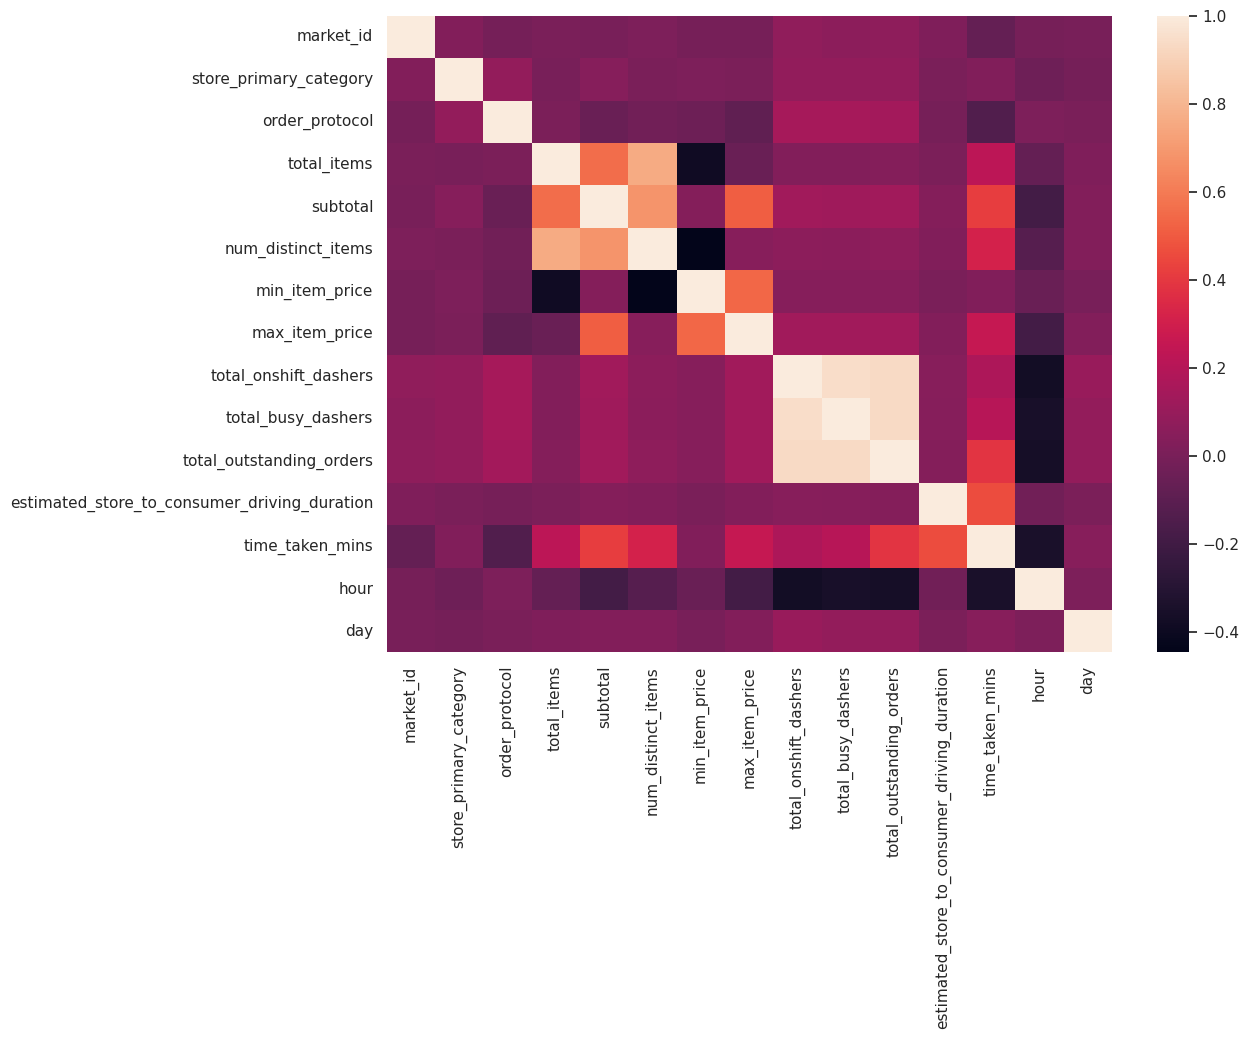

In [20]:
sns.heatmap(df.corr())

we have one categorical column which we will change to integer for model

In [21]:
df['store_primary_category']=df['store_primary_category'].astype('category').cat.codes

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     175777 non-null  float64
 1   store_primary_category                        175777 non-null  int8   
 2   order_protocol                                175777 non-null  float64
 3   total_items                                   175777 non-null  int64  
 4   subtotal                                      175777 non-null  int64  
 5   num_distinct_items                            175777 non-null  int64  
 6   min_item_price                                175777 non-null  int64  
 7   max_item_price                                175777 non-null  int64  
 8   total_onshift_dashers                         175777 non-null  float64
 9   total_busy_dashers                            17

## Data Visualization and Cleaning

<Axes: xlabel='time_taken_mins', ylabel='subtotal'>

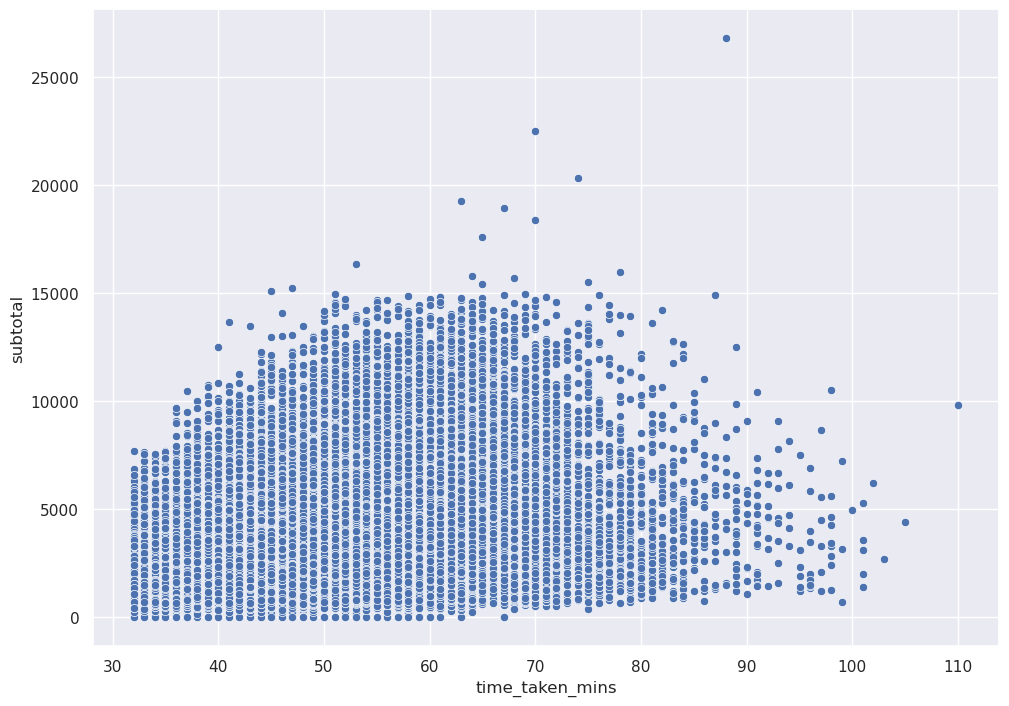

In [23]:
sns.scatterplot(x='time_taken_mins',y='subtotal',data=df)

<Axes: xlabel='total_items', ylabel='subtotal'>

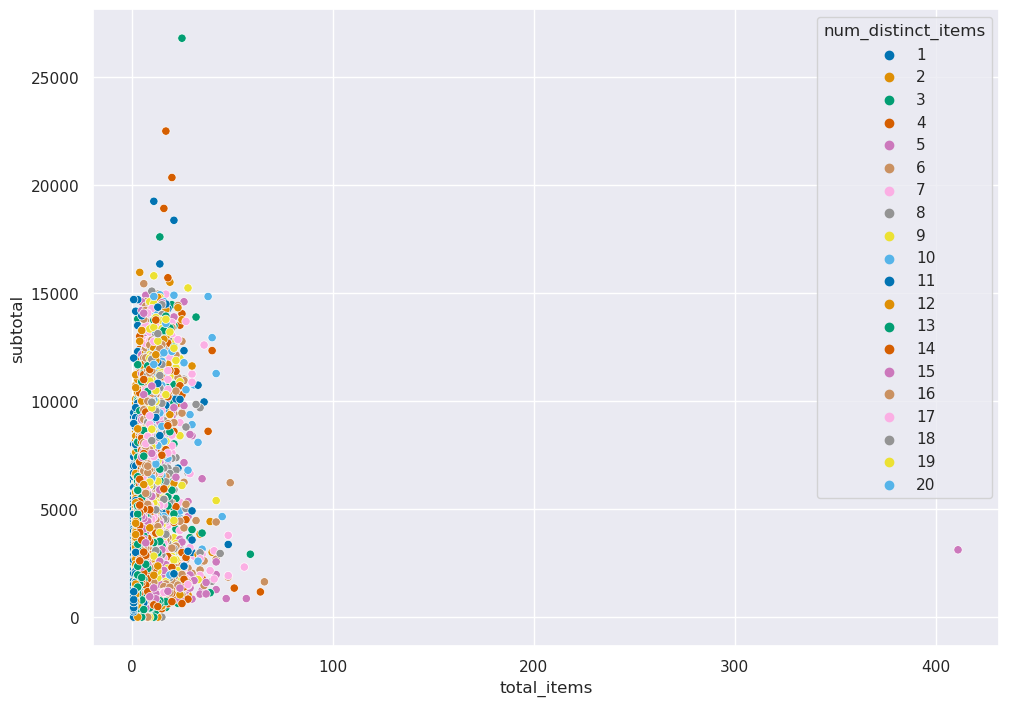

In [24]:
sns.scatterplot(x='total_items',y='subtotal',hue='num_distinct_items',palette='colorblind',data=df)

In [25]:
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
model1=LocalOutlierFactor()
#model1.fit(df)
df['lof_anomaly_score']=model1.fit_predict(df)

In [26]:
print("number of outliers : ",(len(df.loc[(df['lof_anomaly_score'] == -1)])))
df=df.loc[(df['lof_anomaly_score'] == 1)]

number of outliers :  831


In [27]:
df.drop(['lof_anomaly_score'],axis=1,inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174946 entries, 0 to 175776
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     174946 non-null  float64
 1   store_primary_category                        174946 non-null  int8   
 2   order_protocol                                174946 non-null  float64
 3   total_items                                   174946 non-null  int64  
 4   subtotal                                      174946 non-null  int64  
 5   num_distinct_items                            174946 non-null  int64  
 6   min_item_price                                174946 non-null  int64  
 7   max_item_price                                174946 non-null  int64  
 8   total_onshift_dashers                         174946 non-null  float64
 9   total_busy_dashers                            17

<Axes: xlabel='time_taken_mins', ylabel='subtotal'>

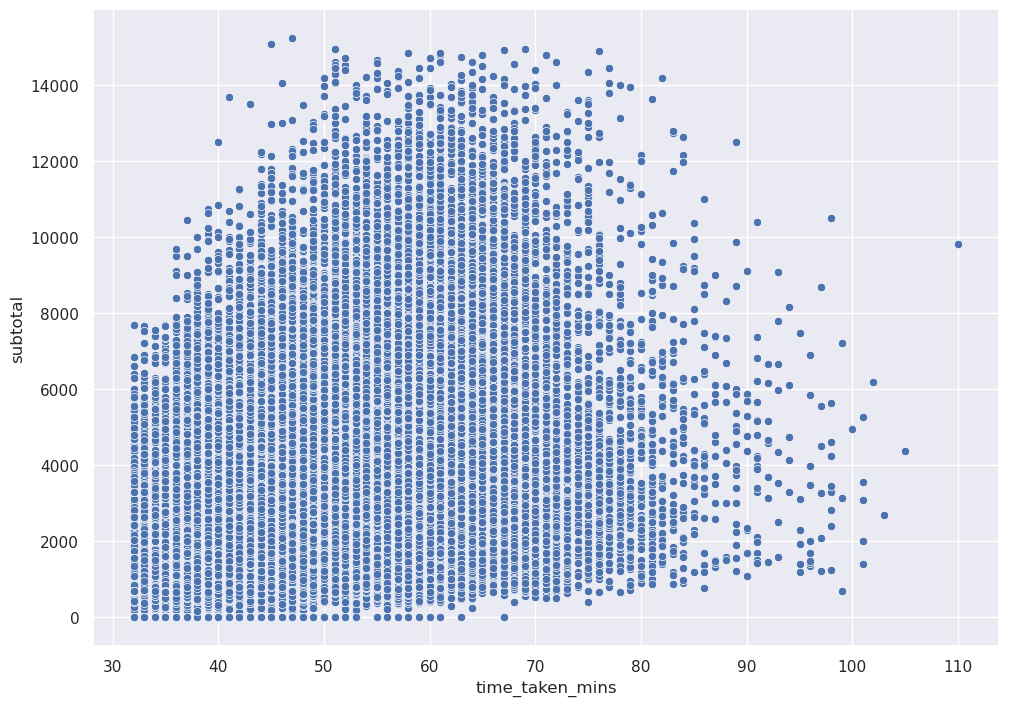

In [29]:
sns.scatterplot(x='time_taken_mins',y='subtotal',data=df)

We can see that after removing outliers our data is looking better

In [30]:
df.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'time_taken_mins',
       'hour', 'day'],
      dtype='object')

<Axes: xlabel='day', ylabel='count'>

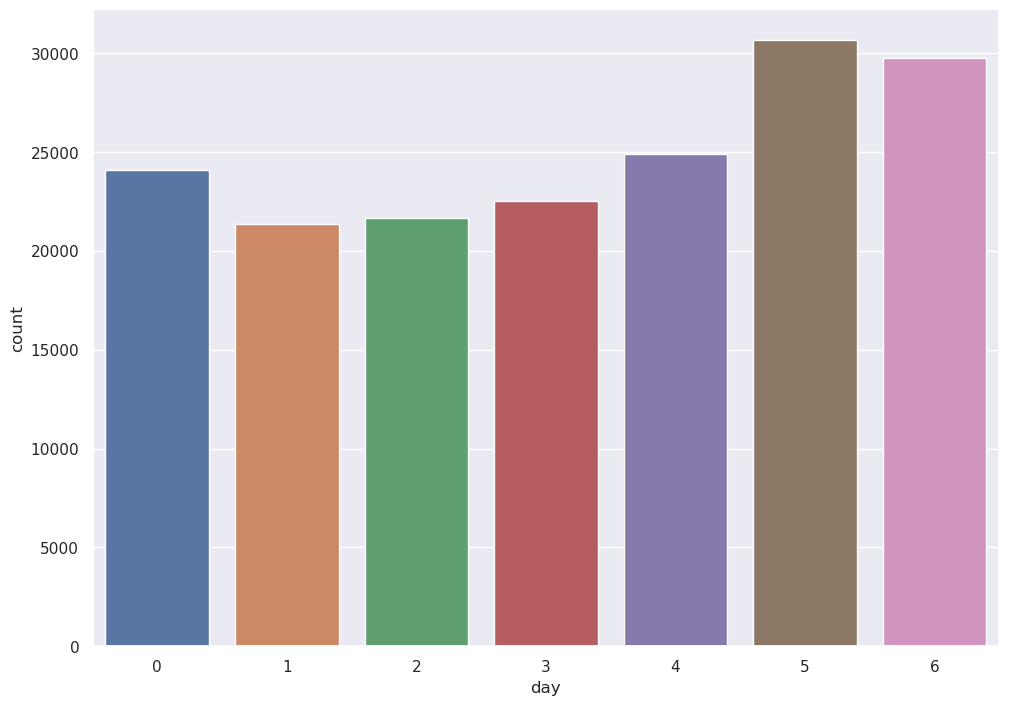

In [31]:
sns.countplot(x=df.day)

a little more orders on the weekends

<Axes: xlabel='hour', ylabel='count'>

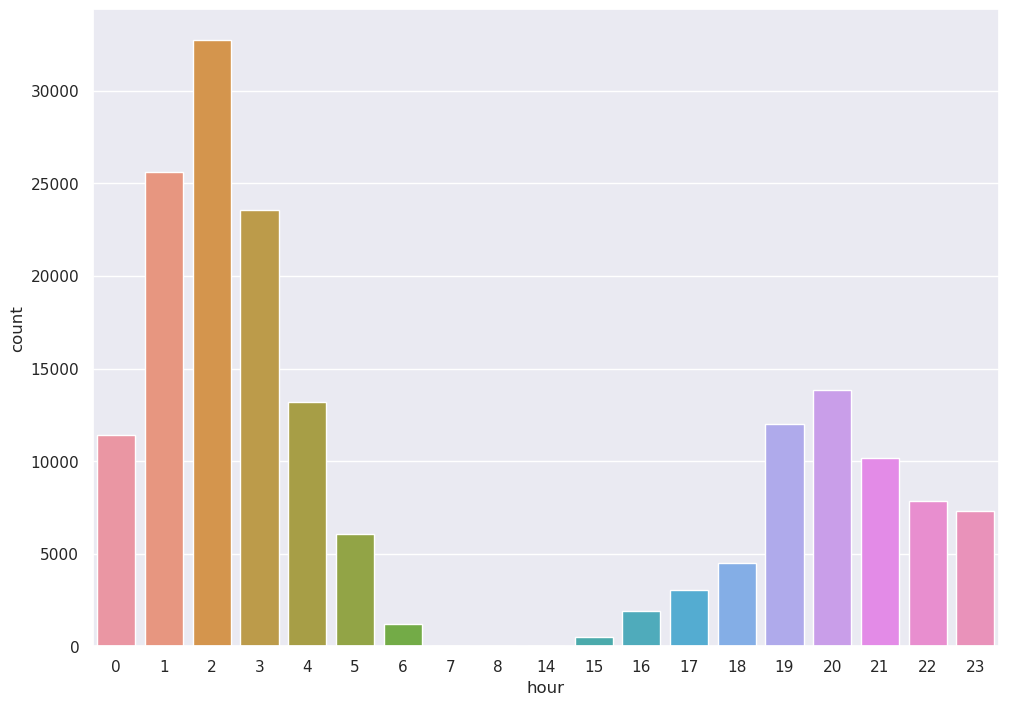

In [32]:
sns.countplot(x=df.hour)

<Axes: xlabel='hour', ylabel='time_taken_mins'>

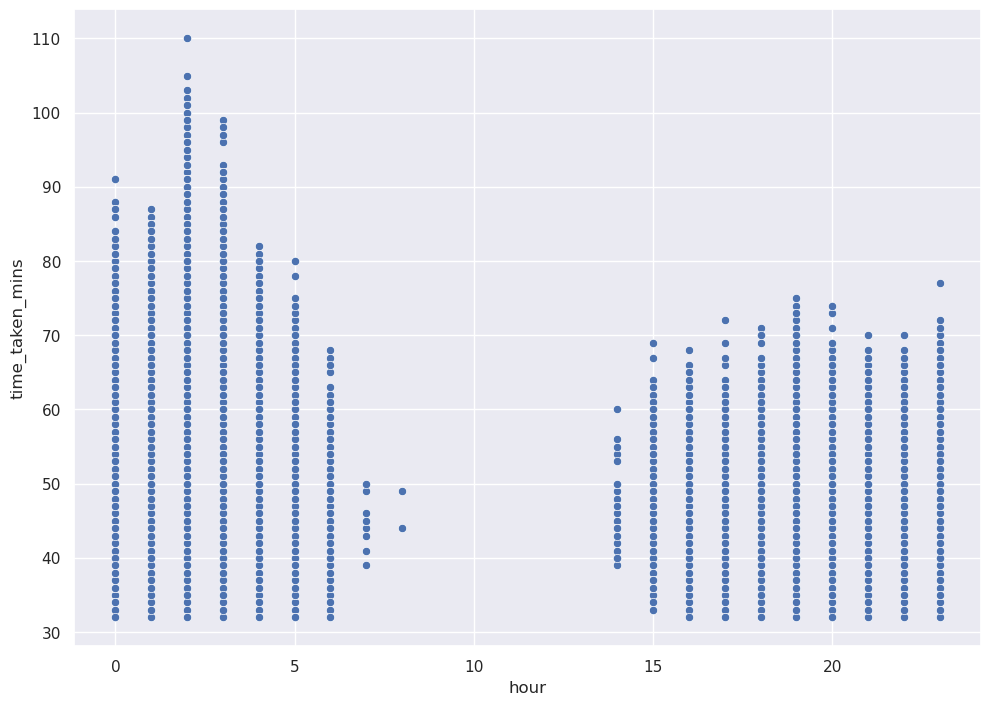

In [33]:
sns.scatterplot(x='hour',y='time_taken_mins',data=df)

## Data Splitting and Modelling

In [34]:
y=df['time_taken_mins']
x=df.drop(['time_taken_mins'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [35]:
x.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,hour,day
0,1.0,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0,22,4
1,2.0,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0,21,1
2,2.0,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0,0,0
3,1.0,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0,3,3
4,1.0,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0,2,1


## **Random Forest**

In [36]:
regressor=RandomForestRegressor()
regressor.fit(X_train,y_train)

RandomForestRegressor()

In [37]:
prediction=regressor.predict(X_test)
mse=mean_squared_error(y_test,prediction)
rmse=mse**.5
print("mse : ",mse)
print("rmse : ",rmse)
mae=mean_absolute_error(y_test,prediction)
print("mase : ",mae)

mse :  3.220806964847099
rmse :  1.7946606823706535
mase :  1.284477565018577


In [38]:
r2_score(y_test,prediction)

0.9625663397276808

In [39]:
def MAPE(Y_actual,Y_Predicted):
    mape=np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [40]:
print("mape : ",MAPE(y_test,prediction))

mape :  2.767850475111929


Text(0.5, 0, 'Random Forest Feature Importance')

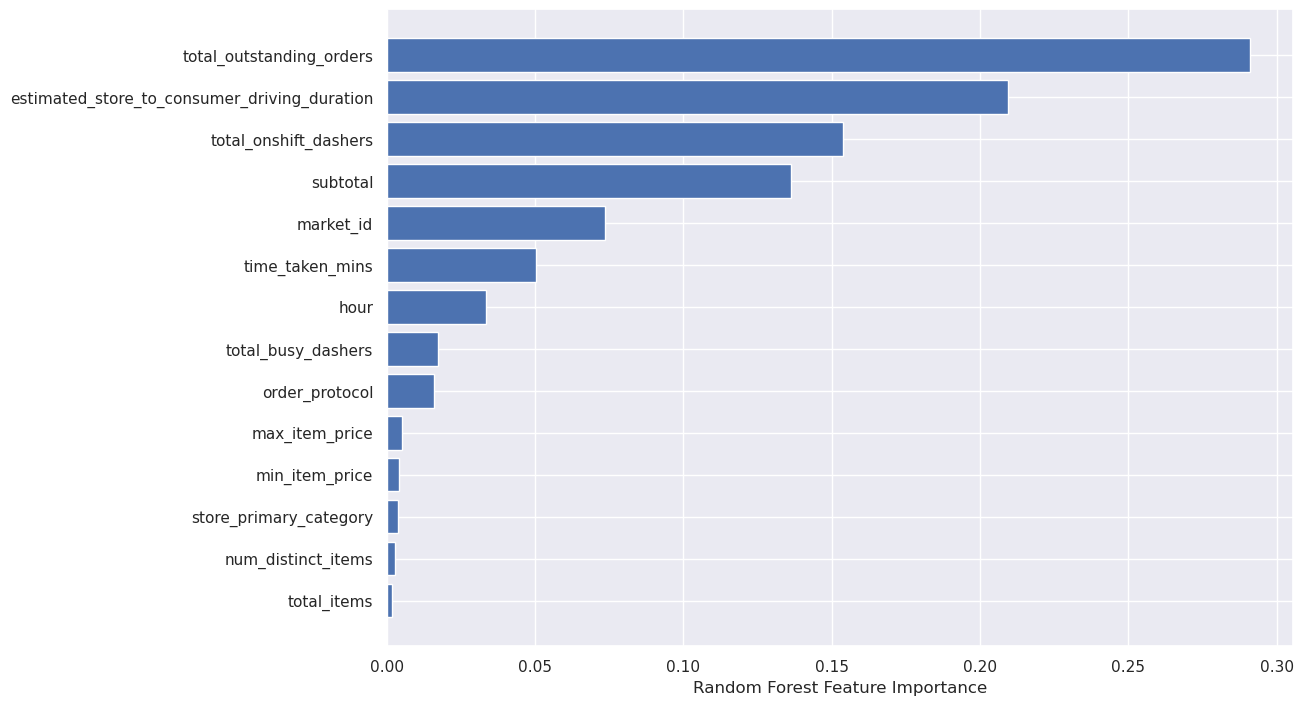

In [41]:
sorted_idx=regressor.feature_importances_.argsort()
plt.barh(df.columns[sorted_idx],regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## **Neural Networks**

Scalling the data to feed before neural network

In [42]:
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler()
x_scaled=scaler.fit_transform(x)
X_train,X_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.2,random_state=42)

We will build a simple neural network to train our regression model
it is a sequential model with three layers,

 we have kept the number of nodes in the first layers equal to the number of input columns, and for the subsequent layers 512,1024,256, which can we changed or experimented with

 the activation for the layers is kept as relu because it is a great non linear activation function that works for most cases, we could have used leaky relu if we see gradient vanishing.

 the last layer has one node because it will give the single result that is our delivery time and the activation function for that should be linear

In [43]:
model=Sequential()
model.add(Dense(14,kernel_initializer='normal',activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='linear'))

we use adam optimizer which is extention to classic schostic gradient descent(SGD) algorithm, but handles much of its drawbacks

Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

In [44]:
from tensorflow.keras.optimizers import Adam
adam=Adam(learning_rate=0.01)
model.compile(loss='mse',optimizer=adam,metrics=['mse','mae'])
history=model.fit(X_train,y_train,epochs=30,batch_size=512,verbose=1,validation_split=0.2)

Epoch 1/30
219/219 [==============================] - 8s 33ms/step - loss: 52.2834 - mse: 52.2834 - mae: 4.0396 - val_loss: 4.3134 - val_mse: 4.3134 - val_mae: 1.4780
Epoch 2/30
219/219 [==============================] - 7s 31ms/step - loss: 3.5259 - mse: 3.5259 - mae: 1.4429 - val_loss: 2.2948 - val_mse: 2.2948 - val_mae: 1.2745
Epoch 3/30
219/219 [==============================] - 7s 33ms/step - loss: 1.8440 - mse: 1.8440 - mae: 1.0729 - val_loss: 2.9157 - val_mse: 2.9157 - val_mae: 1.5713
Epoch 4/30
219/219 [==============================] - 7s 31ms/step - loss: 1.4762 - mse: 1.4762 - mae: 0.9241 - val_loss: 0.5914 - val_mse: 0.5914 - val_mae: 0.6325
Epoch 5/30
219/219 [==============================] - 7s 31ms/step - loss: 1.3536 - mse: 1.3536 - mae: 0.8706 - val_loss: 0.9976 - val_mse: 0.9976 - val_mae: 0.9125
Epoch 6/30
219/219 [==============================] - 7s 31ms/step - loss: 1.3826 - mse: 1.3826 - mae: 0.8289 - val_loss: 0.1740 - val_mse: 0.1740 - val_mae: 0.3337
Epoch 7/

we plot train and validation loss throughout training 

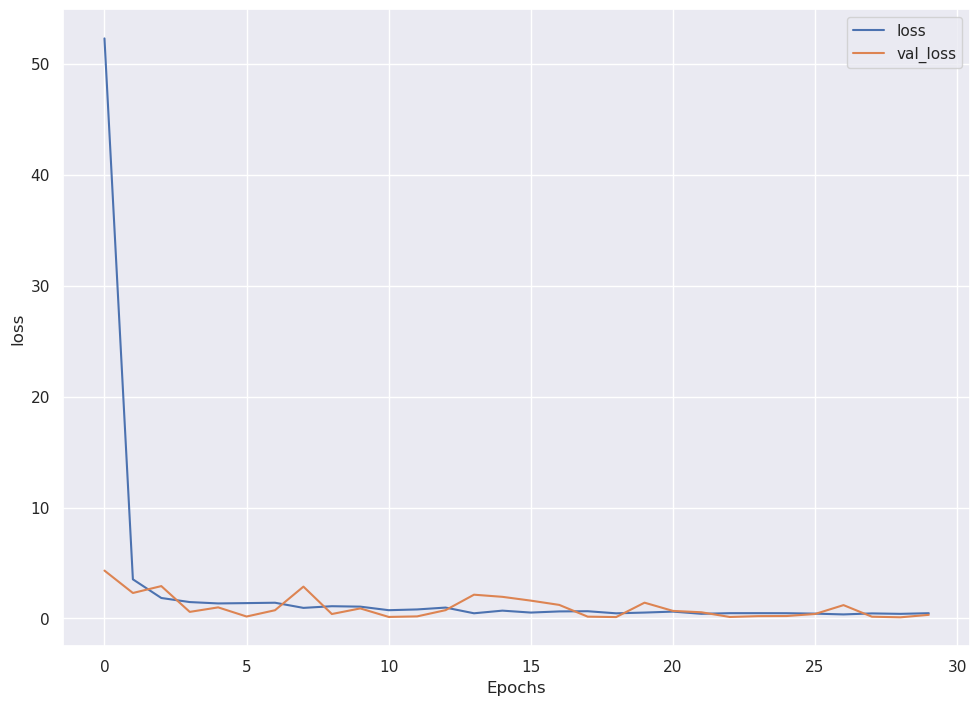

In [45]:
def plot_history(history,key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key,'val_'+key])
    plt.show()
#plot the history
plot_history(history,'loss')

val loss is below training loss so our model is not overfitting

In [46]:
z= model.predict(X_test)

1094/1094 [==============================] - 3s 2ms/step


In [47]:
r2_score(y_test, z)

0.9962313328111876

In [48]:
mse = mean_squared_error(y_test, z)
rmse = mse**.5
print("mse : ",mse)
print("rmse : ",rmse)
print("errors for neural net")
mae = mean_absolute_error(y_test, z)
print("mae : ",mae)

mse :  0.3242576184539861
rmse :  0.5694362286103564
errors for neural net
mae :  0.4739888630856375


In [49]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, z)

0.010204824365605065

By comparing the results of our neural network model with the random forest model we can see that without any tuning or creating pretty complex architectures for training our model we have achieved high accuracy